In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from timeit import default_timer as timer
from scipy.integrate import odeint
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.signal import resample, decimate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from itertools import repeat
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
colors = sns.color_palette(n_colors=10)
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

## Ruido Blanco y Zero-Order Hold (ZOH) para emular un entorno de monitoreo de sensores más realista

El ruido en las mediciones representa una fuente importante de variabilidad en sistemas reales. Se define una función que calcula la potencia de una señal de entrada según la siguiente simplificación:
$$
P_{x_{S}} = \frac{\sum_{i=1}^{N} |x_{S}(t)|^{2}}{N}
$$

Luego la potencia de la señal se puede traducir a decibelios según la siguiente expresión:
$$
P_{x_{S},\text{db}} = 10\cdot \log_{10}(P_{x_{S}})
$$

Luego si se conoce el signal-to-noise-ratio, se puede modelar el ruido según:
$$
P_{noise,\text{db}} = P_{x_{S},\text{db}} - \text{SNR}_{\text{db}}
$$

y luego la magnitud del ruido se obtiene a partir de la operación inversa (distribución uniforme aleatoria):
$$
noise = \text{U}(0, \sqrt{10^{(P_{noise,\text{db}}/10)}})
$$

Además se considera que los sensores poseen un tiempo de muestreo de una milésima de segundo, mientras que la simuláción es de una diezmilpesima de segundo, resultando en que los datos finales generados como datos de sensores de corriente del motor, velocidad angular dele eje del rotor, presion y caudal de salida y entrada, se perderá información debido a menor resolución de los sensores respecto a la simulación y además se agregara ruido gaussiano con SRNs (signal-to-noise-ratio) de 80, 86, 42,56 y 76 decibéles para los sensores de corriente, velocidad angular, caudal, presión de entrada y presión de salida respectivamente.

Para considerar la discretización de la señal continua de la simulación se usa el zero-order-hold. Es un modelo matemático de la reconstrucción práctica de la señal realizada por un convertidor digital-analógico (DAC) convencional. Es decir, describe el efecto de convertir una señal de tiempo discreto en una señal de tiempo continuo manteniendo cada valor de muestra durante un intervalo de muestra.

Una retención de orden cero (ZOH) reconstruye la siguiente forma de onda en tiempo continuo a partir de una secuencia de muestras x[n], suponiendo una muestra por intervalo de tiempo T:

$$
x_{ZOH}(t) = \sum_{n=-\infty}^{\infty} x[n]\cdot \text{rect}\left(\frac{t-T/2 - nT}{T}\right)
$$

donde la función $\text{rect}\left(\cdot\right)$ es la función rectangular, la cual se define como:

$$
\text{{rect}}\left(\frac{{t}}{{a}}\right) = \Pi\left(\frac{{t}}{{a}}\right) = 
\begin{cases} 
0, & \text{{si }} |t| > \frac{{a}}{{2}} \\
\frac{{1}}{{2}}, & \text{{si }} |t| = \frac{{a}}{{2}} \\
1, & \text{{si }} |t| < \frac{{a}}{{2}}
\end{cases}
$$

In [6]:
def add_gaussian_noise(data, SNR_db, change_time, total_time, failure_modes, failure_code, signal_time_resolution, sampling_time):
    failure_mode = np.concatenate(
    (np.array([failure_modes[0]] * int(change_time * (1/sampling_time))), 
     np.array([failure_code] * int((total_time - change_time) * (1/sampling_time))))
    )
    time_hours = np.repeat(np.arange(1, int(len(data) * signal_time_resolution) + 1), (1/sampling_time))
    RUL = time_hours[-1] - time_hours
    measures = []
    continuous_time = np.arange(0, len(data) * signal_time_resolution, signal_time_resolution)
    sampling_ratio = int(sampling_time / signal_time_resolution)
    sample_time = continuous_time[::sampling_ratio]
    for key, value in SNR_db.items():
        signal = data[key] 
        sig_power = np.mean(signal**2)
        sig_power_db = 10 * np.log10(sig_power)
        noise_power_db = sig_power_db - value
        noise_power = 10 ** (noise_power_db / 10)
        noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
        noisy_signal = signal + noise
        measured_signal = noisy_signal[::sampling_ratio]
        measures.append(measured_signal)
    measures.insert(0, sample_time)   
    measures.insert(1, time_hours)
    measures.extend([failure_mode, RUL])
    df = pd.DataFrame(measures).T
    df.columns = ['simulation_time', 'time', 'iMotor_meas', 'wMotor_meas', 'Q_in_meas', 'Q_out_meas', 'P_in_meas', 'P_out_meas', 'failure_mode', 'RUL']
    df['Q_in_meas'] = df['Q_in_meas'] * 60000
    df['Q_out_meas'] = df['Q_out_meas'] * 60000
    df['P_in_meas'] = (df['P_in_meas'] - 101325) / 100000
    df['P_out_meas'] = (df['P_out_meas'] - 101325) / 100000
    return df

Luego se generan los conjuntos de datos de las 14 bombas con las señales "realistas" de sensores generadas con la función ``add_gaussian_noise()``. Los valores del "signal-to-noise ratio (SNR) se determinan de manera arbitraria para cada señal de sensor. A futuro, estos niveles de ruido agregado deben obtenerse a partir de datos de sensores reales para validad los niveles de ruido.

In [21]:
signal_time_resolution = 0.0001
sampling_time = 0.001  
SNR_db = {'iMotor':80, 'wMotor':86, 'Q_in':42, 'Q_out':42, 'P_in':56, 'P_out':76}
total_hours = [1279, 1169, 1418, 1200, 1292, 1462, 1431, 1135, 1252, 1318, 1519, 1431, 1475, 1309]
hours_change = [479, 370, 619, 401, 493, 663, 632, 335, 453, 519, 719, 632, 676, 510]
failure_modes = [
    'None', 'WornBearing', 'LeakSeal', 'BlockedIn', 'WornBearing_BlockedIn', 
    'WornBearing_LeakSeal', 'BlockedIn_LeakSeal', 'WornBearing_BlockedIn', 
    'WornBearing_LeakSeal', 'WornBearing_LeakSeal_BlockedIn', 'WornBearing', 
    'LeakSeal', 'BlockedIn', 'BlockedIn_LeakSeal','WornBearing_LeakSeal_BlockedIn'
] 

In [ ]:
for i in range(9):
    with open('../B0xx_simulation/' + 'B00'+str(i+1)+'_simulation.pkl', 'rb') as f:
        df = pickle.load(f)
    noisy_data = add_gaussian_noise(df, SNR_db, hours_change[i], total_hours[i], failure_modes, failure_modes[i+1], signal_time_resolution, sampling_time)
    noisy_data.insert(loc=1, column='health state', value=noisy_data['failure_mode'].apply(lambda x: 1 if x == 'None' else 0))
    noisy_data.insert(loc=1, column='unit_id', value=['B00' + str(i+1)]*len(noisy_data))
    noisy_data.to_pickle('B0xx_sensored_signals/' + 'B00'+str(i+1)+'.pkl')
    
for i in range(9, 14):
    with open('../B0xx_simulation/' + 'B0'+str(i+1)+'_simulation.pkl', 'rb') as f:
        df = pickle.load(f)
    noisy_data = add_gaussian_noise(df, SNR_db, hours_change[i], total_hours[i], failure_modes, failure_modes[i+1], signal_time_resolution, sampling_time)
    noisy_data.insert(loc=1, column='health state', value=noisy_data['failure_mode'].apply(lambda x: 1 if x == 'None' else 0))
    noisy_data.insert(loc=1, column='unit_id', value=['B0' + str(i+1)]*len(noisy_data))
    noisy_data.to_pickle('B0xx_sensored_signals/' + 'B0'+str(i+1)+'.pkl')

A continuación se muestra una comparación entre las señaes original, con ruido y luego del ZOH.

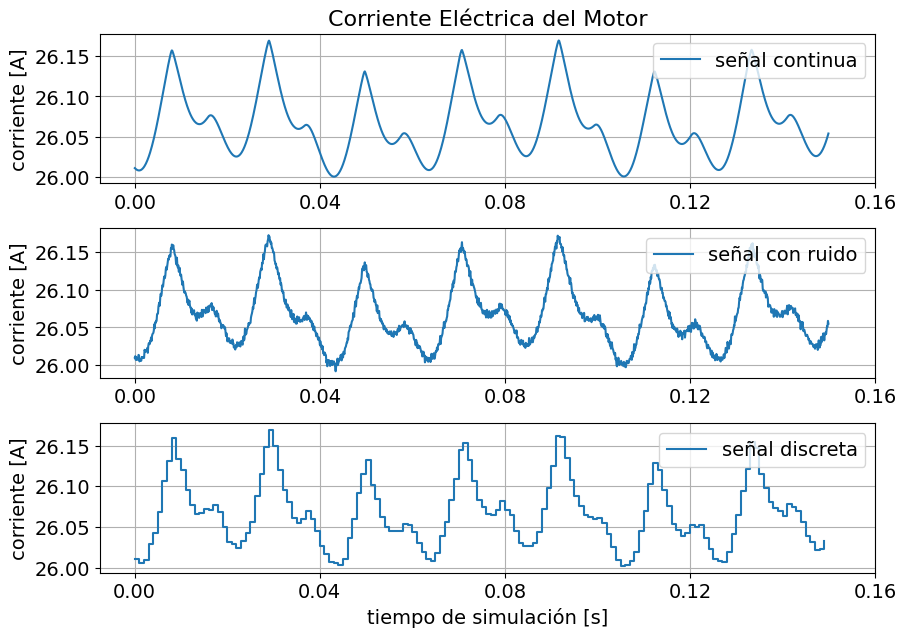

In [10]:
signal_time_resolution = 0.0001
sampling_time = 0.001  

with open('../B0xx_simulation/' + 'B001_simulation.pkl', 'rb') as f:
    data = pickle.load(f)

continuous_time = np.arange(0, len(data) * signal_time_resolution, signal_time_resolution)
sampling_ratio = int(sampling_time / signal_time_resolution)
sample_time = continuous_time[::sampling_ratio]
signal = data['iMotor'] 
sig_power = np.mean(signal**2)
sig_power_db = 10 * np.log10(sig_power)
noise_power_db = sig_power_db - 80
noise_power = 10 ** (noise_power_db / 10)
noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
noisy_signal = signal + noise
measured_signal = noisy_signal[::sampling_ratio]

title_size = 16
body_size = 14
time_length = 1500
plt.figure(figsize=(10, 7))
plt.subplot(3, 1, 1)
plt.plot(continuous_time[:time_length], signal[:time_length], '-', label='señal continua')
plt.title('Corriente Eléctrica del Motor', fontsize=title_size)
plt.ylabel('corriente [A]', fontsize=body_size)
plt.legend(loc='upper right', fontsize=body_size)
plt.xticks(fontsize=body_size)
plt.yticks(fontsize=body_size)
plt.xticks(np.arange(0, continuous_time[:time_length][-1] + 0.0001 + 0.04, 0.04))
plt.grid(True)
plt.subplot(3, 1, 2)
plt.plot(continuous_time[:time_length], noisy_signal[:time_length], '-', label='señal con ruido')
plt.ylabel('corriente [A]', fontsize=body_size)
plt.legend(loc='upper right', fontsize=body_size)
plt.xticks(fontsize=body_size)
plt.yticks(fontsize=body_size)
plt.xticks(np.arange(0, continuous_time[:time_length][-1] + 0.0001 + 0.04, 0.04))
plt.grid(True)
plt.subplot(3, 1, 3)
plt.step(sample_time[:int(time_length/10)], measured_signal[:int(time_length/10)], '-', where='post', label='señal discreta')
plt.ylabel('corriente [A]', fontsize=body_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.legend(loc='upper right', fontsize=body_size)
plt.xticks(fontsize=body_size)
plt.yticks(fontsize=body_size)
plt.xticks(np.arange(0, continuous_time[:time_length][-1] + 0.0001 + 0.04, 0.04))
plt.grid(True)
plt.subplots_adjust(hspace=0.3)
plt.savefig('images/comparing_signal.png', format='png', dpi=300)  

## Ejemplo del conjunto de datos generado para una de las bombas simuladas

In [16]:
with open('B0xx_sensored_signals/B002.pkl', 'rb') as f:
    df = pickle.load(f)
df

,simulation_time,unit_id,health state,time,iMotor_meas,wMotor_meas,Q_in_meas,Q_out_meas,P_in_meas,P_out_meas,failure_mode,RUL
0,0.0,B002,1,1,26.010734,1914.923862,46.729375,40.749675,-0.194181,7.170407,None,1168
1,0.001,B002,1,1,26.008295,1913.95073,48.155628,40.341331,-0.200827,7.16805,None,1168
2,0.002,B002,1,1,26.00847,1913.480113,49.576138,39.614298,-0.203738,7.16692,None,1168
3,0.003,B002,1,1,26.025111,1912.873911,49.448677,39.146088,-0.205881,7.161122,None,1168
4,0.004,B002,1,1,26.048545,1912.925681,48.961195,37.156084,-0.205263,7.156674,None,1168
...,...,...,...,...,...,...,...,...,...,...,...,...
1168995,1168.995,B002,0,1169,25.619514,1903.348141,48.912135,36.062211,-0.203983,7.403275,LeakSeal,0
1168996,1168.996,B002,0,1169,25.714234,1903.937235,45.538375,33.502825,-0.191185,7.384637,LeakSeal,0
1168997,1168.997,B002,0,1169,25.806611,1905.199898,37.045575,31.723035,-0.161528,7.344229,LeakSeal,0
1168998,1168.998,B002,0,1169,25.900878,1906.951663,34.169358,28.64536,-0.141282,7.154228,LeakSeal,0


Luego se muestra una pequeña porción de las señales de los 6 sensores con ruido y ZOH.

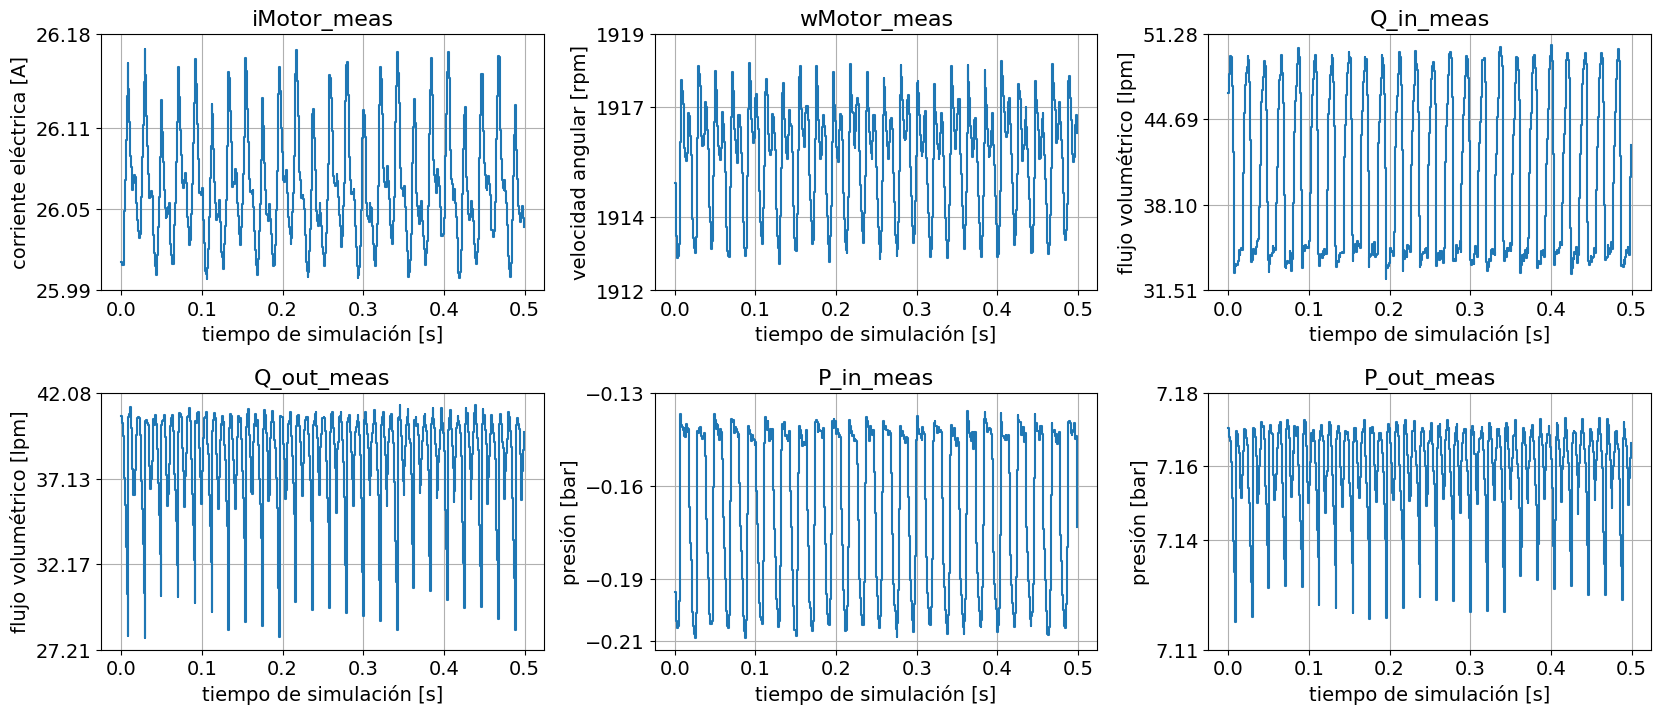

In [17]:
head = 500
simulation_time, iMotor, wMotor, Q_in, Q_out, P_in, P_out =  df['simulation_time'].head(head), df['iMotor_meas'].head(head), df['wMotor_meas'].head(head), df['Q_in_meas'].head(head), df['Q_out_meas'].head(head), df['P_in_meas'].head(head), df['P_out_meas'].head(head)

title_size = 16
body_size = 14
y_axis_values = 4

plt.figure(figsize=(20, 8))
plt.subplot(2, 3, 1)
plt.step(simulation_time, iMotor, '-', where='post')
plt.title('iMotor_meas', fontsize=title_size)
plt.ylabel('corriente eléctrica [A]', fontsize=body_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.xticks(fontsize=body_size)
y_min, y_max = plt.ylim()
y_values = np.linspace(y_min, y_max, y_axis_values)
y_values = np.around(y_values, 2)
plt.yticks(y_values, fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 2)
plt.step(simulation_time, wMotor, '-', where='post')
plt.title('wMotor_meas', fontsize=title_size)
plt.ylabel('velocidad angular [rpm]', fontsize=body_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.xticks(fontsize=body_size)
y_min, y_max = plt.ylim()
y_values = np.linspace(y_min, y_max, y_axis_values)
y_values = np.around(y_values, 0)
plt.yticks(y_values, fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 3)
plt.step(simulation_time, Q_in, '-', where='post')
plt.title('Q_in_meas', fontsize=title_size)
plt.ylabel('flujo volumétrico [lpm]', fontsize=body_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.xticks(fontsize=body_size)
y_min, y_max = plt.ylim()
y_values = np.linspace(y_min, y_max, y_axis_values)
y_values = np.around(y_values, 2)
plt.yticks(y_values, fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 4)
plt.step(simulation_time, Q_out, '-', where='post')
plt.title('Q_out_meas', fontsize=title_size)
plt.ylabel('flujo volumétrico [lpm]', fontsize=body_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.xticks(fontsize=body_size)
y_min, y_max = plt.ylim()
y_values = np.linspace(y_min, y_max, y_axis_values)
y_values = np.around(y_values, 2)
plt.yticks(y_values, fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 5)
plt.step(simulation_time, P_in, '-', where='post')
plt.title('P_in_meas', fontsize=title_size)
plt.ylabel('presión [bar]', fontsize=body_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.xticks(fontsize=body_size)
y_min, y_max = plt.ylim()
y_values = np.linspace(y_min, y_max, y_axis_values)
y_values = np.around(y_values, 2)
plt.yticks(y_values, fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 6)
plt.step(simulation_time, P_out, '-', where='post')
plt.title('P_out_meas', fontsize=title_size)
plt.ylabel('presión [bar]', fontsize=body_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.xticks(fontsize=body_size)
y_min, y_max = plt.ylim()
y_values = np.linspace(y_min, y_max, y_axis_values)
y_values = np.around(y_values, 2)
plt.yticks(y_values, fontsize=body_size)
plt.grid(True)

plt.subplots_adjust(hspace=0.4, wspace=0.25)
plt.savefig('images/sensor_signal_complete.png', format='png', dpi=300)  

## Modificación de la curva de RUL original

Los conjuntos de datos generados consideran que la variable objetivo RUL decrece de manera lineal con el tiempo, de modo que todas las filas que corresponden a una misma muestra tienen el mismo valor de RUL. Sin embargo, en aplicaciones prácticas, la degradación de los equipos durante las etapas iniciales de operación suele ser poco evidente.

In [18]:
sensors = df.iloc[:, 4:-2]
fs = 1000   #group size
sensors_groups = [sensors.iloc[i:i+fs] for i in range(0, len(sensors), fs)]
sensors_groups_mean = pd.concat([pd.DataFrame(sensors_groups[i].mean()).T for i in range(len(sensors_groups))]).reset_index(drop=True)
scaler = MinMaxScaler()
normalized_sensors_groups_mean = scaler.fit_transform(sensors_groups_mean)
normalized_sensors_groups_mean = pd.DataFrame(normalized_sensors_groups_mean, columns=sensors_groups_mean.columns)
normalized_sensors_groups_mean

,iMotor_meas,wMotor_meas,Q_in_meas,Q_out_meas,P_in_meas,P_out_meas
0,0.990612,0.000000,0.421214,0.995183,0.653049,0.998716
1,0.991185,0.032287,0.401847,0.996326,0.575184,0.998671
2,0.990943,0.071180,0.409309,0.997080,0.396855,0.999074
3,0.991468,0.102522,0.665812,0.997383,0.459571,0.998892
4,0.992172,0.109645,0.463707,0.996021,0.606128,0.998788
...,...,...,...,...,...,...
1164,0.009316,0.962644,0.330979,0.008350,0.461381,0.010244
1165,0.006988,0.964039,0.709761,0.007559,0.317450,0.007584
1166,0.004086,0.973049,0.772230,0.006964,0.199764,0.004889
1167,0.001387,0.997033,0.557353,0.007103,0.172197,0.002257


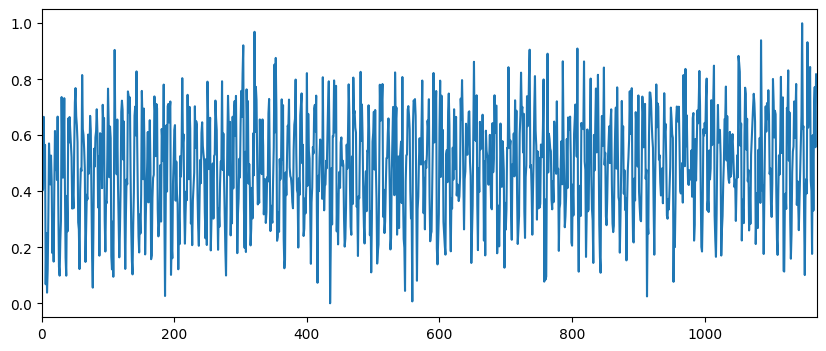

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(normalized_sensors_groups_mean['Q_in_meas'], label='Q_in_meas')
plt.xlim(0, 1169)
plt.savefig('images/raw_sensor_data.png', format='png', dpi=300)  
plt.show()

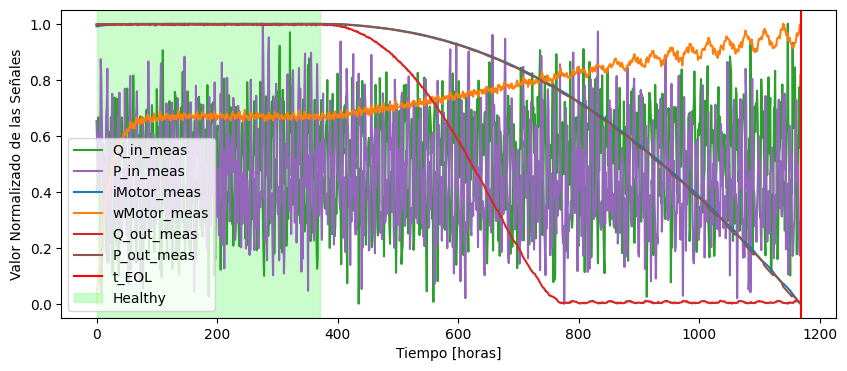

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(normalized_sensors_groups_mean['Q_in_meas'], label='Q_in_meas', color=colors[2])
plt.plot(normalized_sensors_groups_mean['P_in_meas'], label='P_in_meas', color=colors[4])
plt.plot(normalized_sensors_groups_mean['iMotor_meas'], label='iMotor_meas', color=colors[0])
plt.plot(normalized_sensors_groups_mean['wMotor_meas'], label='wMotor_meas', color=colors[1])
plt.plot(normalized_sensors_groups_mean['Q_out_meas'], label='Q_out_meas', color=colors[3])
plt.plot(normalized_sensors_groups_mean['P_out_meas'], label='P_out_meas', color=colors[5])
plt.axvline(total_hours[1], color='r', linestyle='-', label='t_EOL')
plt.axvspan(0, hours_change[1], color='palegreen', alpha=0.5, label='Healthy')
plt.ylabel('Valor Normalizado de las Señales')
plt.xlabel('Tiempo [horas]')
plt.legend()
plt.savefig('images/picewise_RUL_1.png', format='png', dpi=300)  
plt.show()

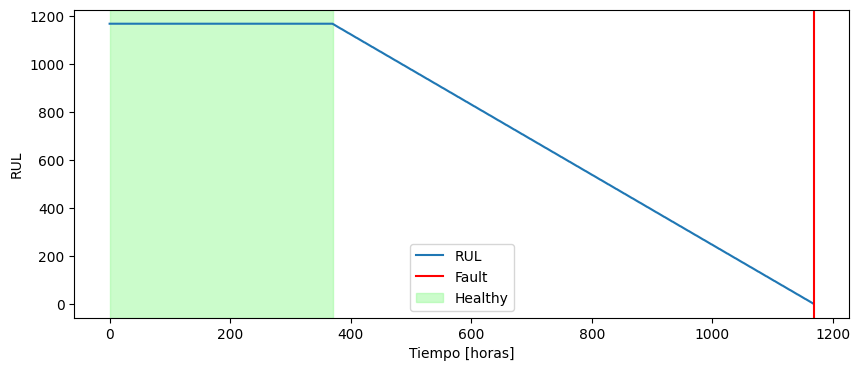

In [23]:
t_s = hours_change[1]
t_EOL = total_hours[1]
time = np.arange(0, t_EOL)
a = -(t_EOL - 1 ) / (t_EOL - t_s)
RUL = np.piecewise(time, [time <= t_s, time > t_s], [(t_EOL - 1 ), lambda t: a * (t - t_s) + (t_EOL - 1 )])
plt.figure(figsize=(10, 4))
plt.plot(RUL, label='RUL')
plt.axvline(t_EOL, color='r', linestyle='-', label='Fault')
plt.axvspan(0, t_s, color='palegreen', alpha=0.5, label='Healthy')
plt.xlabel('Tiempo [horas]')
plt.ylabel('RUL')
plt.legend()
plt.savefig('images/picewise_RUL_2.png', format='png', dpi=300)  
plt.show()
RUL_rep = [elem for elem in RUL for _ in repeat(None, fs)]